In [1]:
import numpy as np
import pandas as pd
import json

# plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

## Read Data

In [2]:
# main data
csv_file = 'data/EXPORT_09042017173622.csv'

# json files to translate gestures, parcours into long text
#gestures_file = 'data/gestures.json' # this is the file edited manually by us to conform to json
gestures_file = 'data/gestures.json.orig' # this is the file edited manually by us to conform to json
parcours_file = 'data/parcours.json'
mutations_file = 'data/mutations.json'

files = (gestures_file, parcours_file, mutations_file)
dataframes = []

# NOTE THAT THESE JSON FILES ARE NOT JSON CONFORM
# each line is a json string on its own, so we need to process the json line by line and combine THEN into a list

In [3]:
def get_oid(oid_dict):
    # get from the original representation {u'$oid': u'589c8ed31337b5ab1e1be121'} just the oid
    return oid_dict['$oid']

In [4]:
for filename in files:
    with open(filename) as f:
        lines = [line.rstrip('\n') for line in f]   # .decode("utf-8")

    lines = [json.loads(line) for line in lines]
    
    # convert list of json lines into Dataframe
    df = pd.DataFrame.from_dict(lines)
    # convert long $oid to short
    df['_id'] = df['_id'].apply(get_oid)
    
    # set the real id
    df.set_index('id', inplace=True)
    
    dataframes.append(df)

In [5]:
(gestures_df, parcours_df, mutations_df) = tuple(dataframes)

In [6]:
gestures_df

,_id,isGarbage,isNesture,name,slug
id,,,,,
G01,58a23a22d826756404709446,NaN,NaN,Single Rotation klein rechtsrum,rssr
G02,58a23a22d826756404709447,NaN,NaN,Single Rotation klein linksrum,rssl
G03,58a23a22d826756404709448,NaN,NaN,Oszillierende Rotation klein rechtsrum,rosr
G04,58a23a22d826756404709449,NaN,NaN,Oszillierende Rotation klein linksrum,rosl
G05,58a23a22d82675640470944a,NaN,NaN,Single Rotation groß rechtsrum,rsbr
G06,58a23a22d82675640470944b,NaN,NaN,Single Rotation groß linksrum,rsbl
G07,58a23a22d82675640470944c,NaN,NaN,Oszillierende Rotation groß rechtsrum,robr
G08,58a23a22d82675640470944d,NaN,NaN,Oszillierende Rotation groß linksrum,robl
G09,58a23a22d82675640470944e,NaN,NaN,Kontinuierliche Rotation groß rechtsrum,rcbr


In [7]:
gestures_df.to_csv('data/gestures.csv', sep=';', encoding='utf-8')

In [8]:
# "positive" gestures to recognize (not nestures)
gestures_pos = gestures_df[gestures_df['isNesture'] != True].index.tolist()

In [9]:
parcours_df

,_id,comment,exercises,pose
id,,,,
P101,589c897d1337b5ab1e1be118,Zwinge X locker rechtsdrehen einzeln 5x,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
P102,589c8ba71337b5ab1e1be11c,Zwinge X locker linksdrehen einzeln 5x,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
P103,589c8dbd1337b5ab1e1be11f,Zwinge X locker rechts- und linksdrehen einzel...,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
P104,589c8ed31337b5ab1e1be121,Zwinge X fest links- und rechtsdrehen einzeln 5x,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
P105,589c8fcc1337b5ab1e1be125,Zwinge X oszilierend linksdrehen,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
P106,589c901a1337b5ab1e1be127,Zwinge X oszilierend rechtsdrehen,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
P107,589c90e31337b5ab1e1be12c,Zwinge Y locker rechtsdrehen einzeln 5x,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
P108,589c911c1337b5ab1e1be12e,Zwinge Y locker linksdrehen einzeln 5x,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
P109,589c91961337b5ab1e1be132,Zwinge Y locker rechts- und linksdrehen einzel...,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...


In [10]:
parcours_df.ix[0,'exercises']

[{u'mutation': {u'id': u'M151'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M101'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M152'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M101'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M152'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M101'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M152'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M101'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M152'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M101'}, u'signal': {u'beep': True}}]

In [11]:
parcours_df.ix[0,'pose']

{u'start': u'Host 008 ist auf Werkbank fixiert, Griffachse X, untere Spannbacke fixiert (Xcm), Gewinde genau in Mitte. Subject steht frontal vor Werkbank, etwas links von Host, F\xfc\xdfe in Schulterbreite, Arme h\xe4ngen locker hinunter.'}

In [12]:
mutations_df

,_id,hands,params,slug
id,,,,
M101,58a24ffa5097dc5998d3c5d0,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaaaaaabaaaba
M102,58a24ffa5097dc5998d3c5d1,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaaaaaabababa
M103,58a24ffa5097dc5998d3c5d2,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaaaaabbaaaba
M104,58a24ffa5097dc5998d3c5d3,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaaaaabbababa
M105,58a24ffa5097dc5998d3c5d4,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaaaaacbaabba
M106,58a24ffa5097dc5998d3c5d5,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaaaaadbabbba
M107,58a24ffa5097dc5998d3c5d6,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaabaaabaaaba
M108,58a24ffa5097dc5998d3c5d7,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaabaaabababa
M109,58a24ffa5097dc5998d3c5d8,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaabaabbaaaba


In [15]:
mutations_df.ix['M101','hands']

{u'right': {u'gesture': {u'id': u'G01'},
  u'host': {u'id': u'H008',
   u'name': u'Schraubzwinge klein',
   u'spot': {u'id': u'A', u'name': u'Drehgriff'}},
  u'instruction': u'Zwinge X locker rechtsdrehen einzeln'}}

In [16]:
mutations_df.ix['M103','params']

[{u'label': u'K\xf6rperhaltung', u'slug': u'm0', u'value': u'stehend'},
 {u'label': u'Spot', u'slug': u'm1', u'value': u'Drehgriff'},
 {u'label': u'Position Spot', u'slug': u'm2', u'value': u'mittig vor Subject'},
 {u'label': u'Orientierung Spot', u'slug': u'm3', u'value': u'Griffachse X'},
 {u'label': u'ausf\xfchrende Hand', u'slug': u'm4', u'value': u'Rechte'},
 {u'label': u'Handhaltung', u'slug': u'm5', u'value': u'Faust'},
 {u'label': u'Widerstand', u'slug': u'm6', u'value': u'Anziehphase'},
 {u'label': u'Drehweise',
  u'slug': u'm7',
  u'value': u'ganze Hand mitbewegen, ganze Hand umgreifen'},
 {u'label': u'Drehwinkel', u'slug': u'm8', u'value': u'90\xb0'},
 {u'label': u'Drehrichtung',
  u'slug': u'm9',
  u'value': u'rechtsrum (schlie\xdfen)'},
 {u'label': u'Bewegungsablauf', u'slug': u'm10', u'value': u'einzeln'},
 {u'label': u'2. Hand', u'slug': u'm11', u'value': u'ruht woanders'}]

In [17]:
mutations_df.ix['M101','hands']['right']['gesture']['id']

u'G01'

### Define handy function shortcuts

In [18]:
def gesture_name(gesture_id):
    if gesture_id is None: return None
    return gestures_df.loc[gesture_id,'name']

In [19]:
def get_mutation_gesture(mutation_id):
    return mutations_df.ix[mutation_id,'hands']['right']['gesture']['id']

## Read Experiment Data

In [20]:
# Experiment Data
data = pd.read_csv(csv_file)
data.shape

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2871: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1435576, 26)

In [21]:
data.shape

(1435576, 26)

In [22]:
data.columns

Index([u'Trainset-ID', u'Experiment-ID', u'Subject-ID', u'Observer-ID',
       u'collectedByHand', u'Collector-ID', u'TimeStamp', u'RFID-ID',
       u'GRASP-A', u'GRASP-B', u'GRASP-C', u'AX', u'AY', u'AZ', u'EX', u'EY',
       u'EZ', u'USERINPUT', u'HANDINGLOVE', u' Parcours-ID', u'Parcours-Step',
       u'Mutation-ID', u' Mutation/HandIsActive', u'Host-ID', u'Host/Spot-ID',
       u'Gesture-ID'],
      dtype='object')

In [23]:
data.dtypes

Trainset-ID                object
Experiment-ID              object
Subject-ID                 object
Observer-ID                object
collectedByHand            object
Collector-ID               object
TimeStamp                   int64
RFID-ID                    object
GRASP-A                     int64
GRASP-B                     int64
GRASP-C                     int64
AX                        float64
AY                        float64
AZ                        float64
EX                        float64
EY                        float64
EZ                        float64
USERINPUT                    bool
HANDINGLOVE                  bool
 Parcours-ID               object
Parcours-Step               int64
Mutation-ID                object
 Mutation/HandIsActive       bool
Host-ID                    object
Host/Spot-ID               object
Gesture-ID                 object
dtype: object

In [24]:
data.head()

,Trainset-ID,Experiment-ID,Subject-ID,Observer-ID,collectedByHand,Collector-ID,TimeStamp,RFID-ID,GRASP-A,GRASP-B,...,EZ,USERINPUT,HANDINGLOVE,Parcours-ID,Parcours-Step,Mutation-ID,Mutation/HandIsActive,Host-ID,Host/Spot-ID,Gesture-ID
0,_TRAINSET14022017094616,E001,Andreas,Clemens,right,R01,0,000000000000,781,8,...,-81.9375,False,True,P101,1,M151,True,H008,NaN,G15
1,_TRAINSET14022017094616,E001,Andreas,Clemens,left,L01,19896,000000000000,212,213,...,-84.5625,False,False,P101,1,M151,False,NaN,NaN,NaN
2,_TRAINSET14022017094616,E001,Andreas,Clemens,right,R01,29001,000000000000,782,0,...,-81.9375,False,True,P101,1,M151,True,H008,NaN,G15
3,_TRAINSET14022017094616,E001,Andreas,Clemens,left,L01,29823,000000000000,179,185,...,-84.5625,False,False,P101,1,M151,False,NaN,NaN,NaN
4,_TRAINSET14022017094616,E001,Andreas,Clemens,right,R01,46136,000000000000,782,6,...,-81.8750,False,True,P101,1,M151,True,H008,NaN,G15


## Some Data Stats

In [25]:
# how many subjects
subjects = data['Subject-ID'].unique().tolist()
subjects 

['Andreas', 'Alfred', 'Claudia', 'Dominik']

In [26]:
# how many observers
data['Observer-ID'].unique().tolist()

['Clemens']

In [27]:
# how many hands
data['Collector-ID'].unique().tolist()

['R01', 'L01']

In [28]:
# how many RFID ids
data['RFID-ID'].unique().tolist()

['000000000000',
 '09006734114B',
 0,
 '05003DD5CD20',
 '760057911BAB',
 '13005E4BB7B1',
 '1400135B8AD6',
 '14001486BE38',
 '7600577D0D51',
 '140014CD1AD7',
 '280015E55981',
 '05008C2F993F']

In [29]:
# how many experiments
experiments = data['Experiment-ID'].unique().tolist()
experiments

['E001', 'E002', 'E003', 'E004', 'E005', 'E006', 'E007', 'E008']

In [30]:
# how many training sets
len(data['Trainset-ID'].unique().tolist())

539

In [31]:
# how many parcours
len(data[' Parcours-ID'].unique())

116

In [32]:
data[' Parcours-ID'].unique()

array(['P101', 'P102', 'P103', 'P104', 'P105', 'P106', 'P107', 'P108',
       'P109', 'P110', 'P111', 'P112', 'P113', 'P114', 'P115', 'P116',
       'P117', 'P118', 'P401', 'P402', 'P403', 'P201', 'P202', 'P203',
       'P204', 'P205', 'P206', 'P207', 'P208', 'P211', 'P212', 'P213',
       'P216', 'P217', 'P218', 'P221', 'P222', 'P223', 'P226', 'P227',
       'P228', 'P701', 'P702', 'P705', 'P706', 'P709', 'P710', 'P713',
       'P714', 'P801', 'P802', 'P601', 'P602', 'P603', 'P606', 'P607',
       'P608', 'P611', 'P612', 'P613', 'P616', 'P617', 'P618', 'P621',
       'P622', 'P623', 'P501', 'P502', 'P504', 'P503', 'P301', 'P302',
       'P306', 'P307', 'P308', 'P311', 'P312', 'P316', 'P317', 'P318',
       'P321', 'P322', 'P326', 'P327', 'P328', 'P119', 'P120', 'P121',
       'P231', 'P232', 'P234', 'P233', 'P236', 'P235', 'P717', 'P718',
       'P719', 'P720', 'P721', 'P722', 'P723', 'P724', 'P626', 'P627',
       'P628', 'P629', 'P630', 'P331', 'P332', 'P333', 'P334', 'P335',
      

In [33]:
# how many parcours steps
data['Parcours-Step'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [34]:
# how many mutations
len(data['Mutation-ID'].unique())

177

In [35]:
# how many gestures
len(data['Gesture-ID'].unique())

19

In [36]:
# which gestures exist
sorted(data['Gesture-ID'].unique())

[nan,
 'G01',
 'G02',
 'G03',
 'G04',
 'G05',
 'G06',
 'G07',
 'G08',
 'G09',
 'G10',
 'G11',
 'G12',
 'G13',
 'G14',
 'G15',
 'G16',
 'G17',
 'G18']

In [37]:
# how many hosts
len(data['Host-ID'].unique())

10

In [38]:
# which Host Spots
data['Host/Spot-ID'].unique().tolist()

[nan, 'A', 'B', 'F']

## Data Preprocessing

In [39]:
# rename some columns as the - in the column name does not allow for data.query()) to be used
# cut off the "-ID" suffix, remove a leading space and replace - by _

for col in data.columns:
    if col.endswith('-ID'):
        data.rename(columns={col: col[:-3]}, inplace=True)
        print "Renamed", col, "->", col[:-3]
        col = col[:-3]
    if col.startswith(' '):
        data.rename(columns={col: col[1:]}, inplace=True)
        print "Renamed", col, "->", col[1:]
        col = col[1:]
    if '-' in col:
        new_col = col.replace('-','_')
        data.rename(columns={col: new_col}, inplace=True)
        print "Renamed", col, "->", new_col

Renamed Trainset-ID -> Trainset
Renamed Experiment-ID -> Experiment
Renamed Subject-ID -> Subject
Renamed Observer-ID -> Observer
Renamed Collector-ID -> Collector
Renamed RFID-ID -> RFID
Renamed GRASP-A -> GRASP_A
Renamed GRASP-B -> GRASP_B
Renamed GRASP-C -> GRASP_C
Renamed  Parcours-ID ->  Parcours
Renamed  Parcours -> Parcours
Renamed Parcours-Step -> Parcours_Step
Renamed Mutation-ID -> Mutation
Renamed  Mutation/HandIsActive -> Mutation/HandIsActive
Renamed Host-ID -> Host
Renamed Host/Spot-ID -> Host/Spot
Renamed Gesture-ID -> Gesture


In [40]:
# remove rows that are not needed:
# all where Gesture-ID is NaN  (implies 'Mutation/HandIsActive' == False and Host is NaN)

data.dropna(axis=0, subset=['Gesture'], inplace=True)

In [41]:
# remove columns that we don't need
# to be ignored as communicated by MOM
cols_to_remove = ['Trainset','USERINPUT', 'HANDINGLOVE', 'Observer','Collector','RFID','Parcours_Step',
                  'Mutation/HandIsActive']

data.drop(cols_to_remove,inplace=True,axis=1)

In [42]:
data.shape

(780299, 18)

In [43]:
data.head()

,Experiment,Subject,collectedByHand,TimeStamp,GRASP_A,GRASP_B,GRASP_C,AX,AY,AZ,EX,EY,EZ,Parcours,Mutation,Host,Host/Spot,Gesture
0,E001,Andreas,right,0,781,8,797,0.06,-0.02,-0.10,216.8125,9.0625,-81.9375,P101,M151,H008,NaN,G15
2,E001,Andreas,right,29001,782,0,799,0.09,-0.04,-0.11,217.0625,9.0625,-81.9375,P101,M151,H008,NaN,G15
4,E001,Andreas,right,46136,782,6,798,0.12,-0.09,0.09,217.4375,9.1250,-81.8750,P101,M151,H008,NaN,G15
6,E001,Andreas,right,74902,784,7,798,0.08,-0.08,0.03,217.6250,9.1250,-81.8125,P101,M151,H008,NaN,G15
8,E001,Andreas,right,97663,781,0,798,0.07,-0.09,0.04,217.9375,9.1875,-81.7500,P101,M151,H008,NaN,G15


In [44]:
# also in this evaluation, we use only one-hand devices and only people who are right-handers
data['collectedByHand'].unique().tolist()

['right', 'left']

In [45]:
# right hand data rows
sum(data['collectedByHand']=='right')

711360

In [46]:
# left hand data rows
sum(data['collectedByHand']=='left')

68939

In [48]:
# REMOVE left hand data, keep only left hand
data = data[data['collectedByHand']=='right']
data.shape

(711360, 18)

### Convert Columns with String IDs to numbers, for later improved efficiency

In [57]:
def str_to_int(string):
    '''cut away first character and convert to int'''
    return int(string[1:])

In [61]:
cols_to_convert = ['Experiment','Parcours','Mutation','Host','Gesture']

for c in cols_to_convert:
    data[c] = data[c].apply(str_to_int)

In [62]:
data.head()

,Experiment,Subject,collectedByHand,TimeStamp,GRASP_A,GRASP_B,GRASP_C,AX,AY,AZ,EX,EY,EZ,Parcours,Mutation,Host,Host/Spot,Gesture
0,1,Andreas,right,0,781,8,797,0.06,-0.02,-0.10,216.8125,9.0625,-81.9375,101,151,8,NaN,15
2,1,Andreas,right,29001,782,0,799,0.09,-0.04,-0.11,217.0625,9.0625,-81.9375,101,151,8,NaN,15
4,1,Andreas,right,46136,782,6,798,0.12,-0.09,0.09,217.4375,9.1250,-81.8750,101,151,8,NaN,15
6,1,Andreas,right,74902,784,7,798,0.08,-0.08,0.03,217.6250,9.1250,-81.8125,101,151,8,NaN,15
8,1,Andreas,right,97663,781,0,798,0.07,-0.09,0.04,217.9375,9.1875,-81.7500,101,151,8,NaN,15


## Look into the Data

In [40]:
data.head()

,Experiment,Subject,collectedByHand,TimeStamp,GRASP_A,GRASP_B,GRASP_C,AX,AY,AZ,EX,EY,EZ,Parcours,Mutation,Host,Host/Spot,Gesture
0,E001,Andreas,right,0,781,8,797,0.06,-0.02,-0.10,216.8125,9.0625,-81.9375,P101,M151,H008,NaN,G15
2,E001,Andreas,right,29001,782,0,799,0.09,-0.04,-0.11,217.0625,9.0625,-81.9375,P101,M151,H008,NaN,G15
4,E001,Andreas,right,46136,782,6,798,0.12,-0.09,0.09,217.4375,9.1250,-81.8750,P101,M151,H008,NaN,G15
6,E001,Andreas,right,74902,784,7,798,0.08,-0.08,0.03,217.6250,9.1250,-81.8125,P101,M151,H008,NaN,G15
8,E001,Andreas,right,97663,781,0,798,0.07,-0.09,0.04,217.9375,9.1875,-81.7500,P101,M151,H008,NaN,G15


In [41]:
data.columns

Index([u'Experiment', u'Subject', u'collectedByHand', u'TimeStamp', u'GRASP_A',
       u'GRASP_B', u'GRASP_C', u'AX', u'AY', u'AZ', u'EX', u'EY', u'EZ',
       u'Parcours', u'Mutation', u'Host', u'Host/Spot', u'Gesture'],
      dtype='object')

### Get Experiment data: Filter for one experiment of one subject

In [335]:
def get_experiment(data,experiment,subject,parcours,mutation,gesture):
    query = []
    # by passing None, some parts of these can be omitted (returning more data)
    if experiment: query.append('Experiment==@exp')
    if subject: query.append('Subject==@subject')
    if parcours: query.append('Parcours==@parcours')
    if mutation: query.append('Mutation==@mutation')
    if gesture: query.append('Gesture==@gesture')
    # TODO filter by Parcours_Step u/o Host
    
    query = " and ".join(query)
    #print query
    return data.query(query)


In [323]:
# get experiment data (setting one to None does not filter by it)
exp = 'E001'
subject = 'Andreas'
parcours = 'P102'
mutation = None
gesture = None #'G02' #'G01'

mydata = get_experiment(data,exp,subject,parcours,mutation,gesture)
mydata.shape

Experiment==@exp and Subject==@subject and Parcours==@parcours


(0, 18)

In [320]:
# if we queried without Parcours, use this to get all the Parcours
mydata['Parcours'].unique().tolist()

['P102']

In [321]:
mut_list = mydata['Mutation'].unique().tolist()
mut_list

['M151', 'M102', 'M153']

In [322]:
gest_list = mydata['Gesture'].unique().tolist()
gest_list

['G15', 'G02', 'G17']

In [300]:
for mut in mut_list:
    gest = get_mutation_gesture(mut)
    print mut, ":", gest, gesture_name(gest)

M102 : G02 Single Rotation klein linksrum


In [301]:
get_experiment(data,exp,subject,parcours,mutation=None,gesture='G15')



Experiment==@exp and Subject==@subject and Parcours==@parcours and Gesture==@gesture


,Experiment,Subject,collectedByHand,TimeStamp,GRASP_A,GRASP_B,GRASP_C,AX,AY,AZ,EX,EY,EZ,Parcours,Mutation,Host,Host/Spot,Gesture
2477,E001,Andreas,right,0,790,10,809,1.29,0.15,-0.24,236.0000,4.1250,-82.5000,P102,M151,H008,NaN,G15
2480,E001,Andreas,right,31090,789,0,807,1.53,0.39,0.19,236.0625,3.7500,-83.0625,P102,M151,H008,NaN,G15
2482,E001,Andreas,right,55174,789,0,808,1.14,0.62,0.64,235.9375,3.5625,-83.7500,P102,M151,H008,NaN,G15
2484,E001,Andreas,right,77280,788,12,808,1.07,0.44,0.63,235.8125,3.6250,-83.8750,P102,M151,H008,NaN,G15
2485,E001,Andreas,right,97476,789,9,808,1.02,0.30,0.53,235.5625,3.8125,-83.8125,P102,M151,H008,NaN,G15
2486,E001,Andreas,right,113645,791,0,809,0.54,0.00,0.17,235.1250,4.0000,-83.5625,P102,M151,H008,NaN,G15
2489,E001,Andreas,right,135236,791,5,809,0.25,-0.15,0.10,234.6250,4.1250,-83.3125,P102,M151,H008,NaN,G15
2491,E001,Andreas,right,166211,788,0,809,-0.19,-0.06,0.21,234.0000,4.1875,-83.1875,P102,M151,H008,NaN,G15
2493,E001,Andreas,right,183683,789,0,809,-0.41,0.01,0.40,233.3125,4.1875,-83.0000,P102,M151,H008,NaN,G15
2496,E001,Andreas,right,224902,790,9,809,-0.40,0.14,0.44,232.6875,4.1875,-82.9375,P102,M151,H008,NaN,G15


### Check TimeStep deltas

In [289]:
def one_plot(mydata,var):
    y = mydata[var]
    x = range(len(y))
    #x = mydata['TimeStamp']
    plt.plot(x, y)
    title = "%s %s %s %s %s %s" % (exp,subject,parcours,mutation,gesture,gesture_name(gesture)) 
    plt.title(title)
    #plt.show()

In [290]:
# investigate time stamp mean and variance
mydata['TimeStamp'].diff().describe()

count       663.000000
mean      27686.944193
std       35440.604695
min         957.000000
25%       17415.500000
50%       24060.000000
75%       28759.000000
max      333752.000000
Name: TimeStamp, dtype: float64

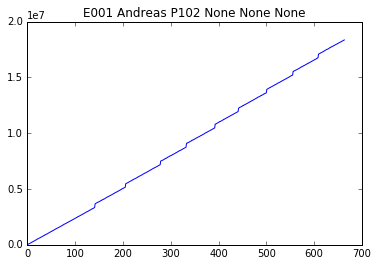

In [295]:
var = 'TimeStamp'
one_plot(mydata,var)

#### TODO: Should we interpolate by event timestamps?


### Visualize timeline of sensor data of an experiment

In [307]:
# TODO GRASP_A B C
params = ['AX', 'AY', 'AZ', 'EX', 'EY', 'EZ']

In [355]:
def grid_plot(mydata, title=True):
    rows = 3
    cols = 2
    fig, axes = plt.subplots(rows, cols, figsize=(16, 10)) #, sharex=True, sharey=True)
    if title is True:
        titlestr = "%s %s %s %s %s %s" % (exp,subject,parcours,mutation,gesture,gesture_name(gesture))
        fig.suptitle(titlestr, fontsize=16)
    elif title is not None:
        fig.suptitle(title, fontsize=16)

    axes_list = axes.reshape(-1)

    for i, var in enumerate(params):

        # data
        y = mydata[var]
        x = range(len(y))
        #x = mydata['TimeStamp']

        # subplot index
        r = i % rows
        c = int(i / rows)
        axes[r,c].plot(x, y)
        axes[r,c].set_title(var)
    

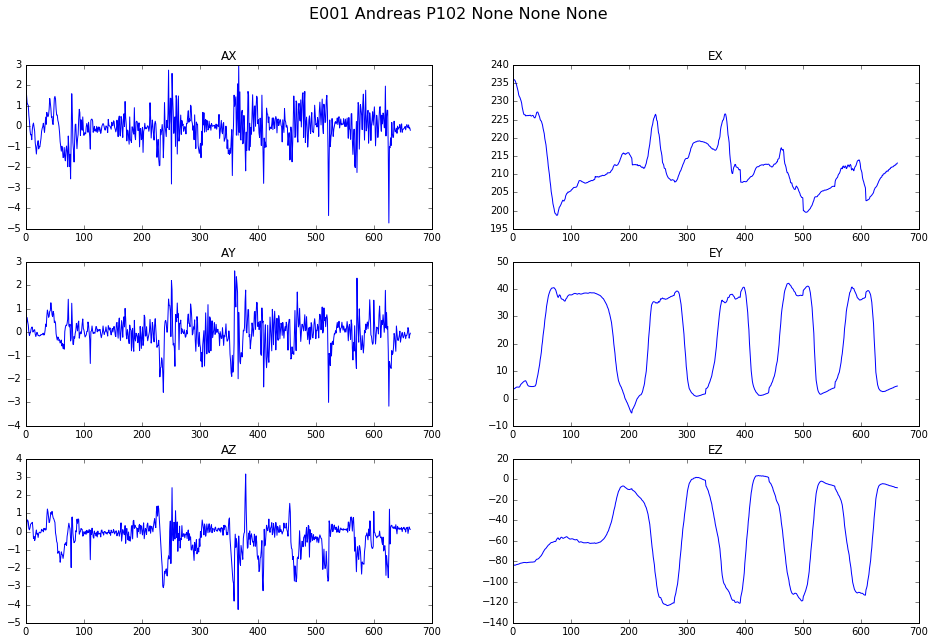

In [296]:
grid_plot(mydata)

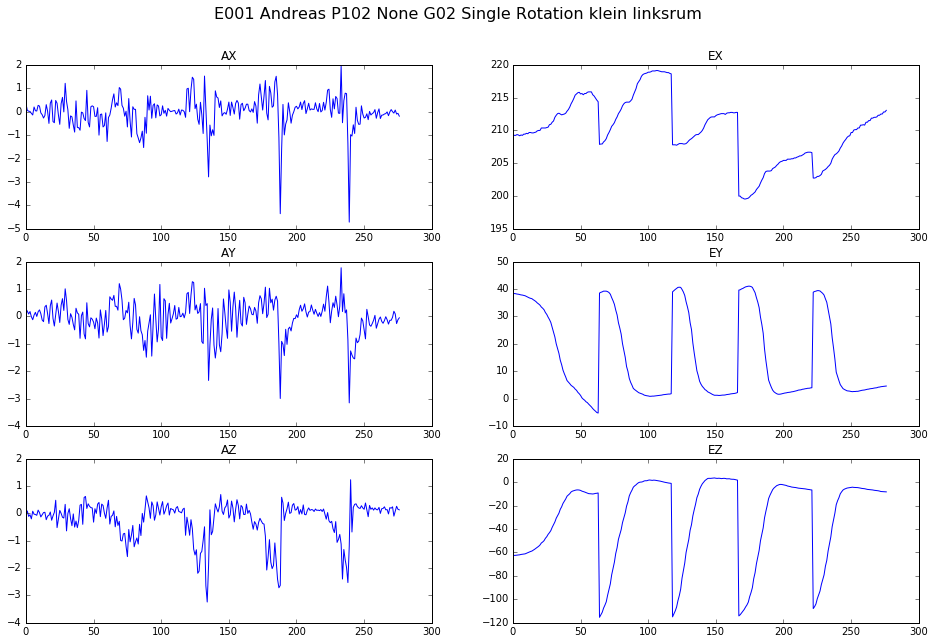

In [302]:
grid_plot(mydata)

In [309]:
gestures_pos

[u'G01',
 u'G02',
 u'G03',
 u'G04',
 u'G05',
 u'G06',
 u'G07',
 u'G08',
 u'G09',
 u'G10',
 u'G11',
 u'G12',
 u'G13']

In [ ]:
# Make groupings by Subject, Experiment, 

In [ ]:
# Iterate over Experiments etc. to group data by gestures

experiments = data['Experiment'].unique().tolist()



In [336]:
# dictionary containing a list of sub-datasets for each gesture, to train ML
gesture_exp_dict = {}

In [344]:
for subject in subjects:
    for exp in experiments:
        
        exp_data = get_experiment(data,exp,subject,parcours=None,mutation=None,gesture=None)
        
        if exp_data.shape[0] > 0:
            # list of parcours in this experiment
            parc_list = exp_data['Parcours'].unique().tolist()
            
            print subject, exp, ":", len(parc_list), "parcours"

#            for parc in parc_list:
            for parc in parc_list[:5]:     # DEBUG: take only first 5 parcours per experiment
                mydata = get_experiment(data,exp,subject,parc,mutation=None,gesture=None)
                mutations = exp_data['Mutation'].unique().tolist()
                gestures = exp_data['Gesture'].unique().tolist() 
                
                print "-", parc, mydata.shape, len(mutations), "mutations", len(gestures), "gestures"
                
                for mut in mutations:
                    mydata = get_experiment(data,exp,subject,parc,mut,gesture=None)
                    gestures = mydata['Gesture'].unique().tolist() 
                    
                    for gest in gestures:
                        mydata = get_experiment(data,exp,subject,parc,mut,gest)
                        print mydata.shape
                        # add data to gesture dict
                        if mydata.shape[0] > 0:
                            if gest not in gesture_exp_dict.keys():
                                gesture_exp_dict[gest] = [] # initalize empty list for this gesture
                            # add data to gesture dict
                            gesture_exp_dict[gest].append(mydata)

Andreas E001 : 57 parcours
- P101 (1238, 18) 89 mutations 10 gestures
(245, 18)
(626, 18)
(367, 18)
- P102 (664, 18) 89 mutations 10 gestures
(195, 18)
(277, 18)
(192, 18)
- P103 (845, 18) 89 mutations 10 gestures
(217, 18)
(362, 18)
(266, 18)
- P104 (889, 18) 89 mutations 10 gestures
(102, 18)
(445, 18)
(342, 18)
- P105 (2368, 18) 89 mutations 10 gestures
(495, 18)
(1873, 18)
Andreas E006 : 59 parcours
- P611 (1205, 18) 111 mutations 17 gestures
(146, 18)
(150, 18)
(417, 18)
(492, 18)
- P612 (816, 18) 111 mutations 17 gestures
(128, 18)
(81, 18)
(286, 18)
(321, 18)
- P613 (889, 18) 111 mutations 17 gestures
(111, 18)
(95, 18)
(381, 18)
(302, 18)
- P616 (1014, 18) 111 mutations 17 gestures
(91, 18)
(200, 18)
(300, 18)
(423, 18)
- P617 (791, 18) 111 mutations 17 gestures
(104, 18)
(79, 18)
(311, 18)
(297, 18)
Alfred E002 : 77 parcours
- P101 (720, 18) 115 mutations 10 gestures
(142, 18)
(268, 18)
(310, 18)
- P102 (531, 18) 115 mutations 10 gestures
(142, 18)
(204, 18)
(185, 18)
- P103 (

In [345]:
for gest in sorted(gesture_exp_dict.keys()):
    print gest, len(gesture_exp_dict[gest]), "data blocks"

G01 16 data blocks
G02 12 data blocks
G03 15 data blocks
G04 16 data blocks
G05 3 data blocks
G06 3 data blocks
G15 41 data blocks
G16 11 data blocks
G17 16 data blocks


In [390]:
# how many data points does each data block have?
data_sizes = [] # collect in list

for gest in sorted(gesture_exp_dict.keys()):
    print gest + ':', 
    for datablock in gesture_exp_dict[gest]:
        size = datablock.shape[0]
        print size,
        data_sizes.append(size)
    print

G01: 626 626 362 342 268 305 325 204 290 203 241 234 274 342 319 318
G02: 277 266 445 204 282 361 265 209 231 307 341 374
G03: 1244 1226 1211 1687 1124 4292 1940 1767 2353 1397 1349 1240 1491 2049 2044
G04: 1873 1789 1199 1660 1535 1223 4442 1974 2748 2428 1598 1763 1694 1864 2233 1794
G05: 417 381 300
G06: 286 302 311
G15: 245 245 195 217 102 495 146 128 111 91 104 142 142 153 115 102 107 95 93 162 106 104 146 102 102 87 221 175 111 177 154 101 249 126 99 119 103 70 95 153 161
G16: 150 81 95 200 79 100 64 108 73 81 117
G17: 367 367 192 492 321 423 297 310 185 270 363 222 235 341 293 352


In [398]:
# average data length (number of samples)
avg_data_len = int(np.mean(data_sizes))
avg_data_len

610

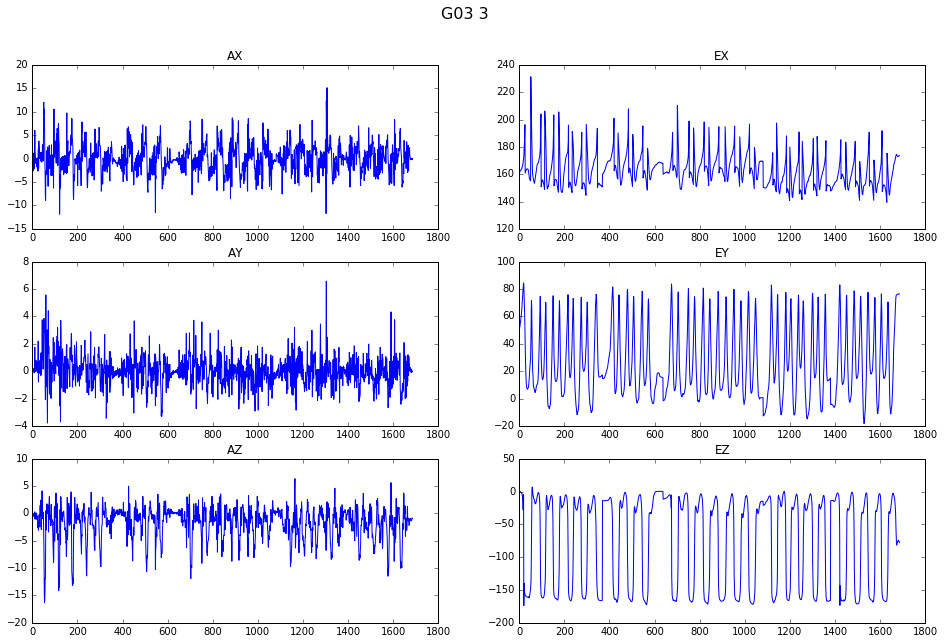

In [357]:
g = 'G03'
i=3
grid_plot(gesture_exp_dict[g][i], title = g + ' ' + str(i))

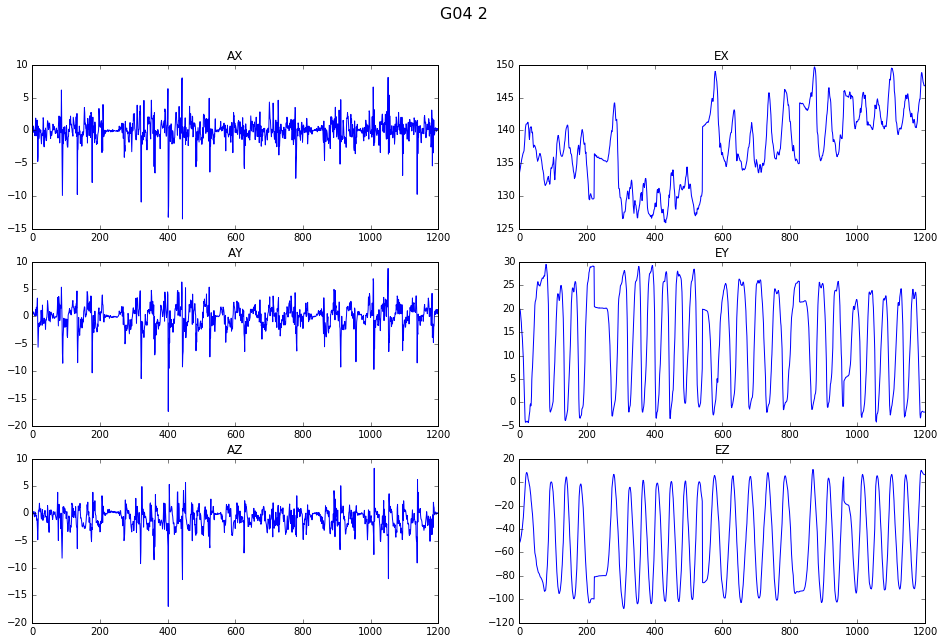

In [362]:
g = 'G04'
i=2
grid_plot(gesture_exp_dict[g][i], title = g + ' ' + str(i))

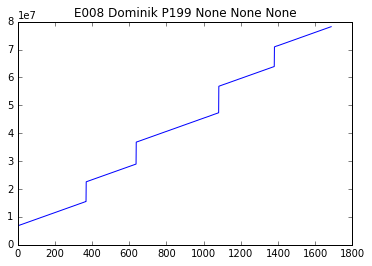

In [356]:
one_plot(gesture_exp_dict[g][i],var='TimeStamp')

### Resampling / Time Normalization

In [380]:
# Time Normalize / Interpolate time stamps

signal_orig = gesture_exp_dict[g][i]['EZ']
signal_orig_timestamps = gesture_exp_dict[g][i]['TimeStamp'].values

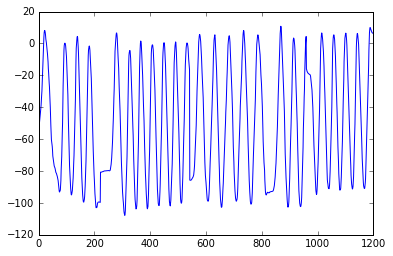

In [369]:
# plot
y = signal_orig
plt.plot(range(len(y)), y)

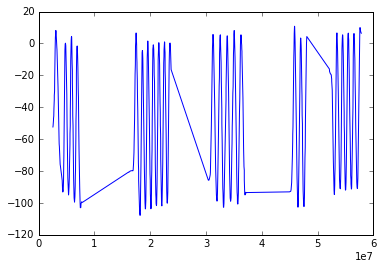

In [375]:
plt.plot(signal_orig_timestamps, signal_orig)

In [399]:
from scipy import stats
from scipy.signal import resample

samples = 500 # should relate to avg_data_len

# If t is given, it is assumed to be the sample positions associated with the signal data in x.
signal_resampled = resample(signal_orig, num=samples) # , t=None,

In [385]:
signal_resampled2, timestamps2 = resample(signal_orig, num=samples, t=signal_orig_timestamps)

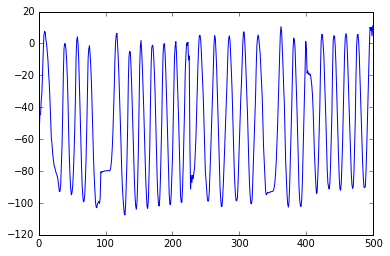

In [371]:
# plot
y = signal_resampled
plt.plot(range(len(y)), y)

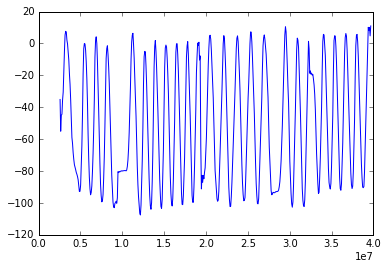

In [387]:
# plot
y = signal_resampled2
plt.plot(timestamps2, y)

In [507]:
# Resample Loop over ALL data

# build new gesture dictionary

gesture_exp_dict_res = {}

for gest in sorted(gesture_exp_dict.keys()):
    print gest + ':', 
    for datablock in gesture_exp_dict[gest]:
        print datablock.shape[0], 
        
        # we can resample the whole block of in put signals
        # transpose: 6 data rows with params, cols is time series
        in_data = datablock[params].T
        
        # resample the whole block, along cols (axis = 1), to target num samples
        signal_resampled = resample(in_data, num=samples, axis=1)
        
        if gest not in gesture_exp_dict_res.keys():
            gesture_exp_dict_res[gest] = [] # initalize empty list for this gesture
        # add data to gesture dict
        gesture_exp_dict_res[gest].append(signal_resampled)
    print



G01: 626 626 362 342 268 305 325 204 290 203 241 234 274 342 319 318
G02: 277 266 445 204 282 361 265 209 231 307 341 374
G03: 1244 1226 1211 1687 1124 4292 1940 1767 2353 1397 1349 1240 1491 2049 2044
G04: 1873 1789 1199 1660 1535 1223 4442 1974 2748 2428 1598 1763 1694 1864 2233 1794
G05: 417 381 300
G06: 286 302 311
G15: 245 245 195 217 102 495 146 128 111 91 104 142 142 153 115 102 107 95 93 162 106 104 146 102 102 87 221 175 111 177 154 101 249 126 99 119 103 70 95 153 161
G16: 150 81 95 200 79 100 64 108 73 81 117
G17: 367 367 192 492 321 423 297 310 185 270 363 222 235 341 293 352


In [506]:
in_data

,421158,421160,421162,421164,421166,421168,421170,421172,421174,421176,...,422252,422255,422257,422259,422261,422263,422265,422267,422269,422270
AX,-0.3500,0.0000,-0.1200,-0.250,-0.0400,0.0200,-0.2000,-0.0500,-0.1500,-0.2700,...,-0.5600,0.430,0.6400,-0.3600,0.0800,0.0500,0.0300,0.0100,-0.0300,-0.2000
AY,0.1000,-0.0400,-0.0200,-0.110,0.0600,0.0000,-0.0800,0.0800,0.0200,0.1200,...,0.0400,-0.100,-0.2800,0.1800,-0.1600,-0.0100,0.1900,-0.0100,0.1100,0.0000
AZ,0.0900,-0.0500,-0.0400,-0.070,-0.0200,0.0400,-0.1900,0.1400,0.0000,0.0500,...,-0.6600,0.000,0.0600,-0.2300,-0.3200,-0.0400,0.0600,0.0400,-0.0800,-0.0200
EX,144.7500,144.5625,144.5625,144.625,144.4375,144.5000,144.1250,144.1250,143.9375,143.9375,...,133.5000,133.375,133.1875,132.9375,132.7500,132.5625,132.4375,132.2500,132.1875,132.0625
EY,19.8125,19.8750,19.8750,19.875,19.8750,19.8750,19.9375,19.9375,19.8750,19.8750,...,-4.9375,-5.000,-5.1250,-5.1875,-5.1875,-5.3125,-5.3750,-5.4375,-5.5000,-5.5000
EZ,-104.7500,-104.6250,-104.5000,-104.375,-104.2500,-104.1875,-104.1250,-104.0000,-104.0000,-103.9375,...,27.8750,28.000,28.0625,28.0625,28.1250,28.1250,28.1250,28.0625,28.0625,28.0000


In [492]:
in_data.shape

(6, 352)

In [493]:
signal_resampled = resample(in_data, num=samples, axis=1)

In [498]:
signal_resampled

array([[ -3.49999994e-01,  -1.06680941e-02,  -7.35666606e-02, ...,
         -6.74116135e-02,   1.79917411e-02,  -3.81142790e-01],
       [  1.00000001e-01,   1.19799832e-02,  -6.09584501e-02, ...,
          1.10971381e-01,   3.41295782e-02,   1.87729684e-02],
       [  9.00000036e-02,  -2.09573511e-02,  -5.83111780e-02, ...,
         -5.74946220e-02,  -1.07612209e-01,   5.48750805e-02],
       [  1.44750000e+02,   1.45842260e+02,   1.43530266e+02, ...,
          1.32595951e+02,   1.30325992e+02,   1.35447520e+02],
       [  1.98125000e+01,   2.23371626e+01,   1.78608997e+01, ...,
         -4.73872425e+00,  -8.95687315e+00,   1.18848115e+00],
       [ -1.04750000e+02,  -1.17518025e+02,  -9.41388197e+01, ...,
          2.40137039e+01,   4.63562788e+01,  -7.27237549e+00]])

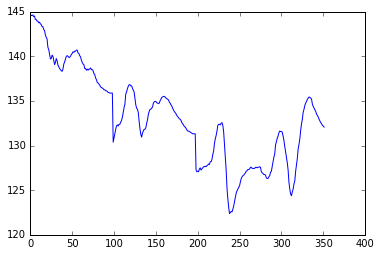

In [504]:
# before
y = in_data.ix['EX']
plt.plot(range(len(y)), y)

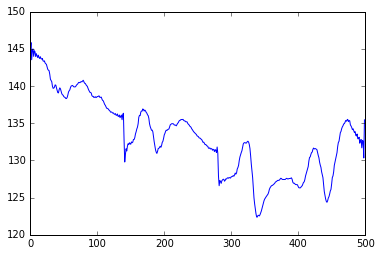

In [503]:
# after
y = signal_resampled[3,:]
plt.plot(range(len(y)), y)

In [ ]:
# optionally scale signal between 0 and 1

# measure ZCR

In [ ]:
# Standardize?

In [ ]:
# TODO Calc derivatives 

### Feature Calculation

In [404]:
# Calc statistical features

def calc_statistical_features(matrix):

    result = np.zeros((matrix.shape[0],6))
    
    result[:,0] = np.mean(matrix, axis=1)
    result[:,1] = np.var(matrix, axis=1, dtype=np.float64) 
    result[:,2] = stats.skew(matrix, axis=1)
    result[:,3] = np.median(matrix, axis=1)
    result[:,4] = np.min(matrix, axis=1)
    result[:,5] = np.max(matrix, axis=1)
#    result[:,3] = stats.kurtosis(matrix, axis=1, fisher=False) # Matlab calculates Pearson's Kurtosis

    result[np.where(np.isnan(result))] = 0
    return result

In [510]:
# LOOP over all gesture data to create features

# initialize feature output for training data as a list
train_list = []
train_classes_str = []
train_classes_num = []

In [511]:

#input_dict = gesture_exp_dict # non resampled
input_dict = gesture_exp_dict_res # resampled


for gest in sorted(input_dict.keys()):
    print gest + ':', len(input_dict[gest]), "examples"
    for datablock in input_dict[gest]:
        print datablock.shape[0], 
        
        # 1) (non-resampled)
        # get the relevant data columns 
        #in_data = datablock[params].T
        
        # 2) resampled
        in_data = datablock
        
        # calc statistical features
        features = calc_statistical_features(in_data)
        #features.shape
        
        # vectorize
        features = features.flatten()
        
        # append to output
        train_list.append(features)
        
        # store class for these features
        train_classes_str.append(gest)
        
        # instead of LabelEncoder, derive number of gesture from string
        train_classes_num.append(int(gest[1:]))
        
    print

G01: 16 examples
6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
G02: 12 examples
6 6 6 6 6 6 6 6 6 6 6 6
G03: 15 examples
6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
G04: 16 examples
6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
G05: 3 examples
6 6 6
G06: 3 examples
6 6 6
G15: 41 examples
6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
G16: 11 examples
6 6 6 6 6 6 6 6 6 6 6
G17: 16 examples
6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6


In [512]:
print "Training data:", len(train_list), "examples"

Training data: 133 examples


In [513]:
# make feature array from feature list (ALL training data)

train_data = np.array(train_list)
#del train_list
train_data.shape

(133, 36)

In [515]:
len(train_classes_str), len(train_classes_num)

(133, 133)

## Machine Learning

In [516]:
from sklearn import preprocessing, svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [517]:
# split the data into train/test set

testset_size = 0.25

# sklearn >= 0.18
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size) #, random_state=0)
splits = splitter.split(train_data, train_classes_num)

# Note: this for loop is only executed once, if n_splits==1
for train_index, test_index in splits:
    print "TRAIN INDEX:", train_index
    print "TEST INDEX:", test_index
    
    # split the data
    train_set = train_data[train_index]
    test_set = train_data[test_index]
    
    # and the numeric classes (groundtruth)
    train_classes = np.array(train_classes_num)[train_index]
    test_classes = np.array(train_classes_num)[test_index]
    

TRAIN INDEX: [ 74  13 113  73  32  66  99  71   3 116 104  20 122  82  68  47 111  95
  58 112 115 129  76  34  42  45  44   7  10  56  19  70  41 117 124  86
  60  51  37  67  17  69  48 114 102  21  29  27   8  61  72 125  79  30
  77  49  23   1  92  87 110  25  89 108  78  39  16  63 130  43  84  83
 131  94  93 132   5  38 123  85  12  64  57 120  91  65  75  11   4   2
 127 126  33  53  54   0  81  26  36]
TEST INDEX: [ 80  59 105  98  88  35   6 119  14 121 118   9  22  96  15  28  52 109
  62  55 100  50 101 128  46 103  90 107 106  18  31  97  24  40]


## Tasks

### 1) Recognize Host + Gesture

(maybe also Subject)

### 2) Recognize Gesture independent of host

In [518]:
# train 

model = OneVsRestClassifier(SVC(kernel='linear'), n_jobs=-1)  # n_jobs = n cpus, -1 = all
# full set
#model.fit(train_data, train_classes_num)
# train set
model.fit(train_set, train_classes)

OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=-1)

In [519]:
# predict on train set

pred_train = model.predict(train_set) #train_data)
pred_train

array([15,  1, 16, 15,  3, 15, 15, 15,  1, 16, 15,  2, 17, 15, 15,  4, 16,
       15,  4, 16, 16, 17, 15,  3,  3,  4,  4,  1,  1,  4,  2, 15,  3, 17,
       17, 15,  5,  4,  3, 15,  2, 15,  4, 16, 15,  2,  3,  2,  1,  5, 15,
       17, 15,  3, 15,  4,  2,  1, 15, 15, 16,  2, 15, 16, 15,  3,  2,  6,
       17,  4, 15, 15, 17, 15, 15, 17,  1,  3,  4, 15,  1,  6,  4, 17, 15,
       15, 15,  1,  1,  1, 17, 17,  3,  4,  4,  1, 15,  2,  3])

In [520]:
train_classes

array([15,  1, 16, 15,  3, 15, 15, 15,  1, 16, 15,  2, 17, 15, 15,  4, 16,
       15,  4, 16, 16, 17, 15,  3,  3,  4,  4,  1,  1,  4,  2, 15,  3, 17,
       17, 15,  5,  4,  3, 15,  2, 15,  4, 16, 15,  2,  3,  2,  1,  5, 15,
       17, 15,  3, 15,  4,  2,  1, 15, 15, 16,  2, 15, 16, 15,  3,  2,  6,
       17,  4, 15, 15, 17, 15, 15, 17,  1,  3, 17, 15,  1,  6,  4, 17, 15,
       15, 15,  1,  1,  1, 17, 17,  3,  4,  4,  1, 15,  2,  3])

In [521]:
# Accuracy on train set
np.sum(pred_train == train_classes) * 1.0 / len(train_classes)

0.98989898989898994

In [522]:
accuracy_score(train_classes, pred_train)

0.98989898989898994

In [523]:
# predict on TEST set

pred_test = model.predict(test_set) 
pred_test

array([15,  5, 15, 15, 15,  1,  2, 15,  1, 17, 17,  1,  1, 15,  1,  4,  4,
       16, 17,  4, 15,  3, 15,  2,  6, 15, 15, 16, 16,  2,  3,  2,  3,  3])

In [524]:
test_classes

array([15,  5, 15, 15, 15,  3,  1, 17,  1, 17, 17,  1,  2, 15,  1,  3,  4,
       16,  6,  4, 15,  4, 15, 17,  4, 15, 15, 16, 16,  2,  3, 15,  2,  3])

In [525]:
# Accuracy on TEST set
accuracy_score(test_classes, pred_test)

0.67647058823529416

In [526]:
precision_score(test_classes, pred_test, average='micro')

0.67647058823529416

In [527]:
recall_score(test_classes, pred_test, average='micro')

0.67647058823529416

In [528]:
precision_score(test_classes, pred_test, average=None)

array([ 0.6       ,  0.25      ,  0.5       ,  0.66666667,  1.        ,
        0.        ,  0.9       ,  1.        ,  0.66666667])

In [529]:
recall_score(test_classes, pred_test, average=None)

array([ 0.75      ,  0.33333333,  0.5       ,  0.5       ,  1.        ,
        0.        ,  0.9       ,  1.        ,  0.5       ])

In [530]:
f1_score(test_classes, pred_test, average=None)

array([ 0.66666667,  0.28571429,  0.5       ,  0.57142857,  1.        ,
        0.        ,  0.9       ,  1.        ,  0.57142857])

In [531]:
labels = sorted(np.unique(test_classes))
labels

[1, 2, 3, 4, 5, 6, 15, 16, 17]

In [533]:
# Confusion Matrix
confusion_matrix(test_classes, pred_test) #, labels=labels)

array([[3, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 2, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 2, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 9, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 3, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 2]])

In [480]:
gestures_df

,_id,isGarbage,isNesture,name,slug
id,,,,,
G01,58a23a22d826756404709446,NaN,NaN,Single Rotation klein rechtsrum,rssr
G02,58a23a22d826756404709447,NaN,NaN,Single Rotation klein linksrum,rssl
G03,58a23a22d826756404709448,NaN,NaN,Oszillierende Rotation klein rechtsrum,rosr
G04,58a23a22d826756404709449,NaN,NaN,Oszillierende Rotation klein linksrum,rosl
G05,58a23a22d82675640470944a,NaN,NaN,Single Rotation groß rechtsrum,rsbr
G06,58a23a22d82675640470944b,NaN,NaN,Single Rotation groß linksrum,rsbl
G07,58a23a22d82675640470944c,NaN,NaN,Oszillierende Rotation groß rechtsrum,robr
G08,58a23a22d82675640470944d,NaN,NaN,Oszillierende Rotation groß linksrum,robl
G09,58a23a22d82675640470944e,NaN,NaN,Kontinuierliche Rotation groß rechtsrum,rcbr


In [ ]:
#-

In [ ]:
# TODO work with Sliding Window ?